In [30]:
import torch as th
import torchvision as thv
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from numpy import random as random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
device = 'cuda'

In [31]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [32]:

image_transforms = transforms.Compose([
    transforms.ToTensor()
])

encoder_data = datasets.ImageFolder("train/",transform=image_transforms)
encoder_data = datasets.ImageFolder("train/",transform=image_transforms)

In [34]:
def plot_images(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

labels:  tensor([0, 4, 3, 2, 2, 6])


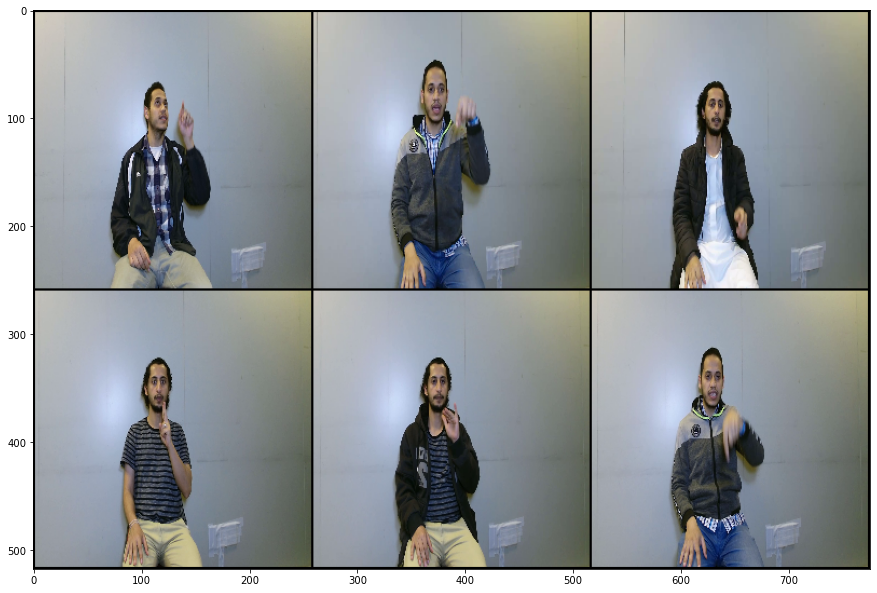

In [35]:
plot_images(encoder_data)

In [38]:
encoder_data

Dataset ImageFolder
    Number of datapoints: 42720
    Root location: train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [54]:
decoder_input = open("groundTruth.txt", encoding='utf-8')
# decoder_input = decoder_input.read().split('\n')
# decoder_input = [decoder_input[i].split(' ') for i in range(len(decoder_input))] 

decoder_input = decoder_input.read()
decoder_input = decoder_input.replace("\n", " ")
decoder_input = np.array(decoder_input.split(" "))

In [57]:
print(decoder_input)


['اسم' 'الله' 'الحمد' 'الله' 'جميع' 'الصم' 'العرب' '' 'السامع' 'السلام'
 'عليكم' 'رحمة' 'الله' 'بركة' 'اليوم' 'اقدم' 'انتم' 'برنامج' 'اخر' 'موضوع'
 'دراسة' 'لغة' 'الاشارة' 'العربية' 'كلمات' 'اليوم' 'متفرقة' 'في' 'الدين'
 'ايضا' 'كلمات' 'عادية' 'لا' 'شرك' 'الله' 'الله' 'اكبر']


In [103]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [104]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [105]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = th.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [106]:
dataloader = DataLoader(encoder_data, batch_size=64, shuffle=True)
INPUT_DIM = len(dataloader.dataset)
OUTPUT_DIM = len(decoder_input)

DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [107]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(42720, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(37, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=37, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [61]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 18,321,189 trainable parameters


In [108]:
optimizer = optim.Adam(model.parameters())

In [109]:
criterion = nn.CrossEntropyLoss()

In [101]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    iterator = len(dataloader)
    for batch in range(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        

        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        

        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [82]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1
import math

dataloader = DataLoader(encoder_data, batch_size=64, shuffle=True)
for epoch in range(N_EPOCHS):
    
    
    train_loss = train(model, dataloader, optimizer, criterion, CLIP)


In [84]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(th.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return th.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return th.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(th.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return th.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):

        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        attn_energies = attn_energies.t()

        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [110]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):

        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        rnn_output, hidden = self.gru(embedded, last_hidden)

        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = th.cat((rnn_output, context), 1)
        concat_output = th.tanh(self.concat(concat_input))

        output = self.out(concat_output)
        output = F.softmax(output, dim=1)

        return output, hidden